<font size = "5"> **EELS_Tools:  [Spectroscopy](../4_EELS_Tools.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# Analysis of EDS Spectra
<br>

[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/Spectroscopy/EDS.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/Spectroscopy/EDS.ipynb)
    
part of 

<font size = "5"> **[pyTEMlib](https://pycroscopy.github.io/pyTEMlib/about.html)**</font>

a [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) ecosystem package



Notebook by Gerd Duscher, 2025

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes

## Content
An Introduction into displaying and analyzing EDS spectrum images and spectra
This works also on Google Colab.


## Prerequesites

### Install pyTEMlib

If you have not done so in the [Introduction Notebook](_.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [2]:
import sys
import importlib.metadata

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2025.10.0':
    print('installing pyTEMlib')
   
    !{sys.executable} -m pip install pyTEMlib --upgrade
# ------------------------------
print('done')

installing pyTEMlib
^C
done
  Using cached pytemlib-0.2025.9.1-py3-none-any.whl.metadata (3.6 kB)
  Using cached ipympl-0.9.8-py3-none-any.whl.metadata (8.9 kB)
  Using cached pyNSID-0.0.7.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached sidpy-0.12.8-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached SciFiReaders-0.12.0-py2.py3-none-any.whl.metadata (3.2 kB)
  Using cached cytoolz-1.1.0-cp313-cp313-win_amd64.whl.metadata (5.3 kB)
  Using cached dask-2025.10.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached pyUSID-0.0.12-py2.py3-none-any.whl.metadata (2.4 kB)
  Using cached gdown-5.2.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached distributed-2025.10.0-py3-none-any.whl.metadata (3.4 kB)
Using cached pytemlib-0.2025.9.1-py3-none-any.whl (1.2 MB)
Using cached pyNSID-0.0.7.2-py2.py3-none-any.whl (12 kB)
Using cached dask-2025.10.0-py3-none-any.whl (1.5 MB)
Using cached SciFiReaders-0.12.0-py2.py3-none-any.whl (96 kB)
Using cached sidpy-0.12.8-py2.py3-none-any.whl (112 kB)
U

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\gduscher\\AppData\\Local\\anaconda3\\envs\\pytem\\Lib\\site-packages\\sidpy\\base\\num_utils.py'
Consider using the `--user` option or check the permissions.



In [8]:
!{sys.executable} -m pip install git+https://github.com/pycroscopy/SciFiReaders/ --no-deps 


  Cloning https://github.com/pycroscopy/SciFiReaders/ to c:\users\gduscher\appdata\local\temp\pip-req-build-zkaotzie
  Resolved https://github.com/pycroscopy/SciFiReaders/ to commit fb2240287146546aee81ca571455fe79d77f8104
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for SciFiReaders: filename=scifireaders-0.12.3-py3-none-any.whl size=128133 sha256=66bc262c115ee6812d7c3f655321ca6001dd3fe3d023a61488592f8810c0599c
  Stored in directory: C:\Users\gduscher\AppData\Local\Temp\pip-ephem-wheel-cache-7ib1eiwm\wheels\20\9a\20\c9d215f9eebd1f3fb361aed40de91fa265dbc16708c396fb54
Successfully built SciFiReaders
  Attempting uninstall: SciFiReaders
    Found existing installation: SciFiReaders 0.12.0
   

  Running command git clone --filter=blob:none --quiet https://github.com/pycroscopy/SciFiReaders/ 'C:\Users\gduscher\AppData\Local\Temp\pip-req-build-zkaotzie'


### Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets.



In [4]:
%matplotlib widget
import sys
import numpy as np
import matplotlib.pylab as plt

# using  pyTEMlib.eds_tools, pyTEMlib.file_tools and pyTEMlib.eels_tools (for line definitions)
sys.path.insert(0, '..//..//')
sys.path.insert(0, '..//..//..//SciFiReaders//')


%load_ext autoreload
%autoreload 2
import SciFiReaders
    
import pyTEMlib

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

if 'google.colab' in sys.modules:
    drive.mount("/content/drive")

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__ = 'EDS_Spectrum_Analysis'
__notebook_version__ = '2025_10_27'

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
pyTEM version:  0.2025.11.0


## Open File

### Load File

Select a main dataset and any additional data like reference data and such.

In [5]:
# C:\Users\gduscher\OneDrive - University of Tennessee\google_drive\2022 Experiments\Spectra\20221214\AlCe-200kV
fileWidget = pyTEMlib.file_tools.FileWidget()

AttributeError: 'Dataset' object has no attribute 'energy_scale'

In [6]:
import h5py
fileWidget.file_name
h5_file = h5py.File(fileWidget.file_name, mode='r+')



In [7]:
h5_file['Data'].keys()

<KeysViewHDF5 ['Image', 'Spectrum', 'SpectrumImage', 'SpectrumStream', 'Text']>

In [16]:
h5_file['Data']['SpectrumStream']['0aa3fc3c3bdc48aaa628f6b964e259cb']['Metadata'].keys()

AttributeError: 'Dataset' object has no attribute 'keys'

In [50]:
import json
stream_key = '0aa3fc3c3bdc48aaa628f6b964e259cb'
data_array = h5_file['Data/SpectrumStream/' + stream_key]['Data']
metadata_array = h5_file['Data/SpectrumStream/' + stream_key]['Metadata'][:, 0]
metadata_string = metadata_array.tobytes().decode("utf-8")
metadata = dict(json.loads(metadata_string.rstrip('\x00')))
if 'AcquisitionSettings' in h5_file['Data/SpectrumStream/' + stream_key]:
    metadata['AcquisitionSettings'] = json.loads(h5_file['Data/SpectrumStream/' + stream_key]['AcquisitionSettings'][0])

In [ ]:
def get_stream(data, size, data_stream, bin_xy):
    """ Get the EDS spectrum from the stream."""
    #for value in self.data_array[:, 0]:
    #from tqdm.auto import trange, tqdm
    pixel_number = 0
    frame = 0
    print(data.shape)
    for value in data_stream:
        if value == 65535:
            pixel_number += 1
            if pixel_number >= size:
                pixel_number = 0
                frame += 1
        else:
            data[pixel_number, int(value)] += 1
    return data, frame

In [52]:
metadata.keys()
acquisition = metadata.get('AcquisitionSettings', {})

scan_area = acquisition.get('Scan', {}).get('ScanArea', {})
scan_size = acquisition.get('Scan', {}).get('ScanSize', {})
if len(scan_area) * len(scan_size) > 0:
    size_x = float(scan_size.get('width', 1)) * float(scan_area.get('right', 1))
    size_x -= float(scan_size.get('width', 1)) * float(scan_area.get('left', 0))
    size_y = float(scan_size.get('height', 1)) * float(scan_area.get('bottom', 1))
    size_y -= float(scan_size.get('height', 1)) * float(scan_area.get('top', 0))
    size_x = int(size_x)
    size_y = int(size_y)
else:
    raster_scan = acquisition.get('RasterScanDefinition', {})
    size_x = int(raster_scan.get('Width', 1))
    size_y = int(raster_scan.get('Height', 1))

size_x, size_y
spectrum_size = int(acquisition.get('bincount', 0))
spectrum_size
bin_xy = 1
data_array2 = np.zeros((int(size_x*size_y), int(spectrum_size/bin_xy)),dtype=np.ushort)

data, frame = get_stream(data_array2, size_x*size_y, data_array[:, 0], bin_xy)




(262144, 4096)
65535
65535
342
2
65535
65535
65535
65535
65535
65535
65535


### Select and Plot Dataset

Select a dataset from the drop down value and display it with the code cell below.

Here we sum the spectra of the 4 quadrants and define the detector parameter.

In [2]:
help(fileWidget)

NameError: name 'fileWidget' is not defined

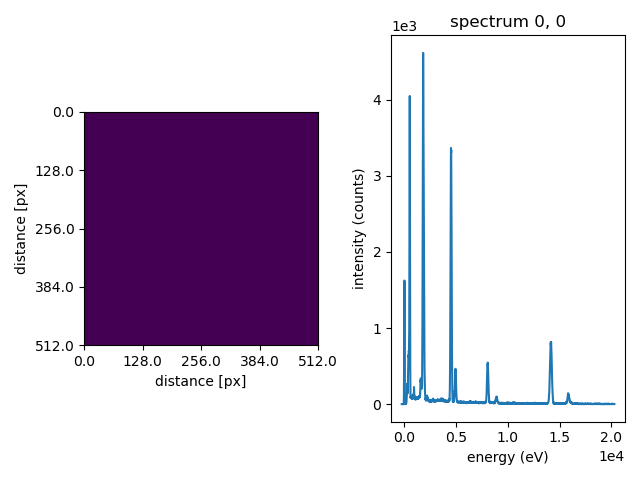

In [ ]:
spectrum = fileWidget.selected_dataset
start = np.searchsorted(spectrum.energy_scale.values, 100)
energy_scale = spectrum.energy_scale.values[start:]
detector_Efficiency= pyTEMlib.eds_tools.detector_response(spectrum)  # tags, spectrum.energy_scale.values[start:])
if 'start_energy' not in spectrum.metadata['EDS']['detector']:
    spectrum.metadata['EDS']['detector']['start_energy'] = 120
spectrum[:np.searchsorted(spectrum.energy_scale.values,spectrum.metadata['EDS']['detector']['start_energy'])] = 0.
spectrum.metadata['EDS']['detector']['detector_efficiency']  = detector_Efficiency
view = spectrum.plot()

## Find Elements 

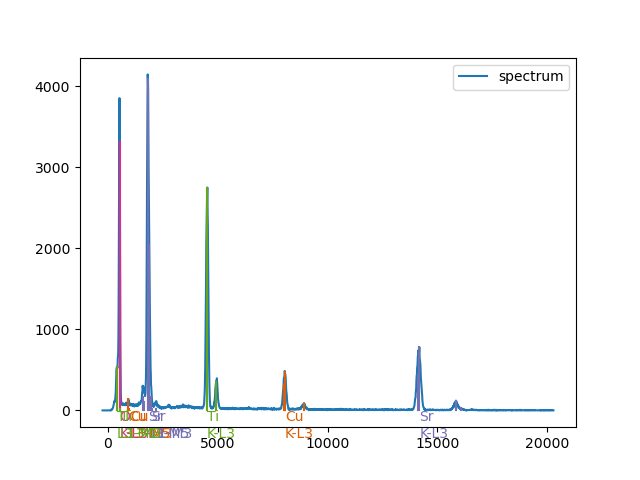

In [21]:
# --------Input -----------
minimum_number_of_peaks = 10
# --------------------------

pyTEMlib.eds_tools.get_elements(spectrum, minimum_number_of_peaks, verbose=False)

plt.figure()
plt.plot(spectrum.energy_scale,spectrum, label = 'spectrum')
pyTEMlib.eds_tools.plot_lines(spectrum.metadata['EDS'], plt.gca())
plt.legend()


In [26]:
spectrum.metadata

{'Z': 38,
 'K-family': {'main': 'K-L3',
  'weight': 1.0,
  'lines': ['K-L3', 'K-L2', 'K-M3', 'K-N3', 'K-M2', 'K-M5'],
  'height': np.float64(782.0),
  'K-L3': {'weight': 1.0, 'position': 14165.000000000002},
  'K-L2': {'weight': 0.564, 'position': 14097.800000000003},
  'K-M3': {'weight': 0.144, 'position': 15835.500000000002},
  'K-N3': {'weight': 0.0328, 'position': 16084.700000000003},
  'K-M2': {'weight': 0.0731, 'position': 15824.800000000003},
  'K-M5': {'weight': 0.000368, 'position': 15971.500000000002}},
 'L-family': {'main': 'L3-M5',
  'weight': 1.0,
  'lines': ['L3-M5',
   'L3-M4',
   'L3-M1',
   'L2-N3',
   'L2-M4',
   'L2-M3',
   'L2-N1',
   'L2-M1',
   'L1-M3',
   'L1-M2',
   'L1-N2',
   'L1-N3'],
  'height': np.float64(4091.0),
  'L3-M5': {'weight': 1.0, 'position': 1806.5},
  'L3-M4': {'weight': 0.114, 'position': 1804.6},
  'L3-M1': {'weight': 0.0412, 'position': 1582.1},
  'L2-N3': {'weight': 0.00524, 'position': 1986.9},
  'L2-M4': {'weight': 0.499, 'position': 1871.

## Quantify

### Fit spectrum

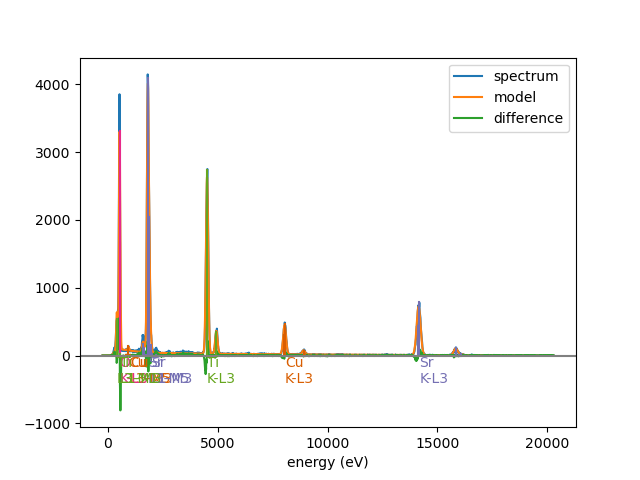

In [27]:
peaks, pp = pyTEMlib.eds_tools.fit_model(spectrum, use_detector_efficiency=True)
model = pyTEMlib.eds_tools.get_model(spectrum)

plt.figure()
plt.plot(spectrum.energy_scale, spectrum, label='spectrum')
plt.plot(spectrum.energy_scale, model, label='model')
plt.plot(spectrum.energy_scale, spectrum-model, label='difference')
plt.xlabel('energy (eV)')
pyTEMlib.eds_tools.plot_lines(spectrum.metadata['EDS'], plt.gca())
plt.axhline(y=0, xmin=0, xmax=1, color='gray')
plt.legend()

### Quantify Spectrum
first with Bote-Salvat cross section
using dictionaries calculated with [emtables package](https://github.com/adriente/emtables/blob/main/).

In [40]:
pyTEMlib.eds_tools.quantify_eds(spectrum, mask =['Cu'])

using cross sections for quantification
Sr: 20.57 at% 45.29 wt%
O : 51.02 at% 20.51 wt%
Ti: 28.42 at% 34.20 wt%


then with k-factor dictionary

In [42]:
q_dict = pyTEMlib.eds_tools.load_k_factors()
tags = pyTEMlib.eds_tools.quantify_eds(spectrum, q_dict, mask = ['Cu'])

using k-factors for quantification
Sr: 21.87 at% 49.34 wt%
O : 55.62 at% 22.91 wt%
Ti: 22.51 at% 27.74 wt%
excluded from quantification  ['Cu']


### Absorption Correction
Lower energy lines will be more affected than higher x-ray lines.

At thin sample location (<50nm) absorption is not significant.

In [1]:
# ------ Input ----------
thickness_in_nm = 90
# -----------------------
pyTEMlib.eds_tools.apply_absorption_correction(spectrum, thickness_in_nm)
for key, value in spectrum.metadata['EDS']['GUI'].items():
    if 'corrected-atom%' in value:
        print(f"Element: {key}, Corrected Atom%: {value['corrected-atom%']:.2f}, Corrected Weight%: {value['corrected-weight%']:.2f}")

NameError: name 'pyTEMlib' is not defined

## Summary
The spectrum is modeled completely with background and characteristic peak-families.

Either 
- k-factors in a file (here from Spectra300) or
- Bothe-Salvat cross-sections
 
are used for quantification.

## Appendix
### Background
The determined background used for the model-based quantification is based on the detector effciency.

Note:

The detector efficiency is also used for the quantification model.
